# Predict early readmission for diabetes patients based on their laboratory and medications record 

In this lab, we are going to use a dataset of diabetes patients. We will build a model to predict whether each patient will be readmitted within 30 days of a hospital visit based on laboratory tests performed and medications taken during their stay.

**We will take the following steps:**

* Load and explore the dataset
> The dataset we use is provided by the Health Facts, while it is extracted and analyzed in the following research work: Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, John N. Clore, "Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records", *BioMed Research International*, vol. 2014, Article ID 781670, 11 pages, 2014. https://doi.org/10.1155/2014/781670
>	

* Use scikit-learn to conduct feature engineering and model training
> We train a classifier to predict early readmission based on encounter records except specific sensitive features. There are both numerical and categorical features in the dataset and we will apply appropriate feature transformation techniques before fitting into the model. Here we will also focus on how to use sklearn.pipeline.Pipeline to assemble the operations. 

* Evaluate models’ performance with different metrics
> Once we obtain the model,  we will explore a series of performance metrics  and observes how they serve differently when it comes to model evaluation for our problem, especially given its extremely unbalanced rate between positive and negative outcomes.  

**Then, we will use [Fairlearn](https://fairlearn.github.io), which  is a Python toolkit to assist in assessing and mitigating unfairness in machine learning models. We will use Fairlearn to:**
 
* Assess model's sensitivity in terms of various fairness and accuracy metrics
>Sensitive features relevant to our task include patients’ race, gender and age. We will use modules provided in Fairlearn to assess model's sensitivity when it comes to any individual of these features, or under the intersection of them. We will also quantify disparities among subgroups with different methods provided. Furthermore, we will introduce the concept about control features and how you can conduct relevant analysis with Fairlearn.  

* Mitigate unfairness observed in the model
>There are three groups of mitigation methods provided in Fairlearn: preprocessing, reduction and postprocessing. We select a specific postprocessing algorithm to mitigate the observed unfairness in the model we trained.

We would like to thank Roman Lutz, who is one of the main contributors to Fairlearn, sincerely for  
his suggestions and assistance in the preparation of this material.




## Step 0: Setups  

In [3]:
!pip install --upgrade raiwidgets==0.2.0
!pip install --upgrade fairlearn==v0.6.0
!pip install -U scikit-learn==0.24.1

  Using cached scikit_learn-0.24.1-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Step 1: Data loading
The original data files can be download as supplementary of the paper at https://www.hindawi.com/journals/bmri/2014/781670/#supplementary-materials. 

Here we provide a link to the shared csv file which you can use to read into your own working space on colaboratory.   

Link: https://drive.google.com/file/d/1giYXkbuR0QWAAni3_GmuUJIvJI69aoDO/view?usp=sharing 

Let's use PyDrive to load the data.

In [2]:
# Packages for reading csv file into Colaboratory:
!pip install -U -q PyDrive==1.3.1

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client. 
# Please follow the steps as instructed when you run the following commands. 

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
# Load the same with information provided above in the link. 
fileid = '1giYXkbuR0QWAAni3_GmuUJIvJI69aoDO'   
filename = 'diabetic_data_preprocessed.csv'
downloaded = drive.CreateFile({'id':fileid}) 
downloaded.GetContentFile(filename)  
data = pd.read_csv(filename)

In [5]:
# Check the data loaded.
data.head()

,Unnamed: 0,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type
0,0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,NaN
1,1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30,Emergency
2,2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,Emergency
3,3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,Emergency
4,4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,Emergency


In [6]:
# Map id to actual meaning of admission type and create a column named 'admission_type' in the data frame.
names = ['Emergency', 'Urgent', 'Elective', 'Newborn', 'Not Available', 'NULL', 'Trauma Center', 'Not Mapped']

data['admission_type'] = [names[i-1] for i in data.admission_type_id]


## Step 2: Data exploration

In the paper, Strack et al extracted and selected the above data from the Health Facts database based on the following criteria:    

1. It is an inpatient encounter (a hospital admission).
2. It is a “diabetic” encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
3. The length of stay was at least 1 day and at most 14 days.
4. Laboratory tests were performed during the encounter.
5. Medications were administered during the encounter.

In the preprocessed data that we'll use in the following analysis, there are 54,742 encounters identified and 49 features selected by clinical experts. Features include demographics, diagnoses, diabetic medications, number of visits in the year preceding the encounter, and payer information. More details about each feature can be found in Table 1 in the paper.

Let's verify the above statements with the data loaded by checking basic stats of it! 

In [7]:
# Get a summary of the dataset with pandas.  
data.describe()

,Unnamed: 0,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,54742.000000,5.474200e+04,5.474200e+04,54742.000000,54742.000000,54742.000000,54742.000000,54742.000000,54742.000000,54742.000000,54742.000000,54742.000000,54742.000000,54742.000000
mean,49354.746374,1.614251e+08,5.585997e+07,2.119360,3.469676,5.629955,4.218936,43.382302,1.466223,15.629224,0.266852,0.090534,0.171733,7.183351
std,29713.535809,1.045316e+08,4.011112e+07,1.527472,5.080940,4.195691,2.936630,20.005624,1.771965,8.419023,1.027293,0.493677,0.591503,2.022203
min,0.000000,1.252200e+04,3.780000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,24324.250000,8.251844e+07,2.334330e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,47017.500000,1.446917e+08,5.113054e+07,1.000000,1.000000,7.000000,3.000000,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000,8.000000
75%,75534.750000,2.267177e+08,8.783425e+07,3.000000,3.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,0.000000,9.000000
max,101765.000000,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,121.000000,6.000000,81.000000,36.000000,42.000000,12.000000,16.000000


Final definition and preparation for 
* target variable
* sensitive features
* features as model inputs



In [8]:
'''
Target variable, readmitted, is binarized as below: 
  =1:  “readmitted” if the patient was readmitted within 30 days of discharge or 
  =0:   “otherwise” which covers both readmission after 30 days and no readmission at all. 
''' 
Y = (data['readmitted']=='<30').astype('int')
print(f'Readmitted rate within 30 days of discharge in the dataset={sum(Y==1)/len(Y)*100:1.3f}%')

Readmitted rate within 30 days of discharge in the dataset=3.957%


In [9]:
#Sensitive and control variables including demographics, severity and type of the disease, and type of admission.
sensitive_control_features = ['race', 'gender', 'age', 
          'admission_type', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
          ]
A = data[sensitive_control_features]
X_raw = data.drop(columns=['readmitted', 'encounter_id', 'patient_nbr'] + sensitive_control_features)

In [10]:
from sklearn.model_selection import train_test_split

#Denoting categorical variables 
for col in ['max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
          'num_medications', 'number_outpatient', 'number_emergency',
          'number_inpatient', 'number_diagnoses',
          'diag_1', 'diag_2', 'diag_3',
       ]:

    X_raw[col] = X_raw[col].astype('category')

(X_train, X_test, y_train, y_test, A_train, A_test) = train_test_split(
    X_raw, Y, A, test_size=0.5, random_state=10000, stratify=Y
)

# Ensure indices are aligned between X, y and A,
# after all the slicing and splitting of DataFrames
# and Series

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
A_train = A_train.reset_index(drop=True)
A_test = A_test.reset_index(drop=True)

## Step 3: Train a classifier to predict early readmission based on encounter records and evaluate its performance.

### Use **sklearn.pipeline.Pipeline** to perform feature engineering and to train a classifier.

**scikit-learn** or **sklearn** is a python module consisting of simple and efficient tools for predictive data analysis (preprocessing, feature selection, dimensionality reduction, regression, classification, clustering, et cetera).

**sklearn.pipeline.Pipeline** object takes a list of **transforms** and a final **estimator** and applies them sequentially on data.
- The possible transforms are preprocessing (e.g., MinMaxScaler, OneHotEncoder), missing value imputation (e.g., KNNImputer, SimpleImputer), dimensionality reduction (e.g., PCA), label encoding (e.g., LabelBinarizer), etc. Any transformers in the pipeline must implement fit and transform methods. For a more complete list, see: https://scikit-learn.org/stable/data_transforms.html

- The final part of the pipeline, the estimator, needs to implement a fit function at the least. The estimators can be classifiers, regressors, etc. For a more complete list, see: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

The purpose of setting up a pipeline is to allow the different transforms and estimator to be cross-validated together when setting their parameters. It also allows for the application of a pre-configured pipeline on new raw data. The different steps of the pipeline and their parameters can be accessed using their 'names'.

In [11]:
from sklearn.linear_model import LogisticRegression

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline

unmitigated_predictor = Pipeline(
    steps=[
           #feature engineering component 
        ("preprocessor", ColumnTransformer(transformers=[
                                              # we use selector to indentify features based on its data type
                                              # Normalize numerical features
                                               ("num", StandardScaler(), selector(dtype_exclude="category")), 
                                              # Encoding (transforming) categorical features to what understandable by the model
                                              ("cat", OneHotEncoder(handle_unknown="ignore"), selector(dtype_include="category")),
                                            ]
                                          )
        ),
        # model component
        ("classifier",
         LogisticRegression(penalty='l2', C=0.1, verbose=0, max_iter=1000, 
                            class_weight={0:1, 1:10}),
        ),
    ]
)

## Step 4: Calculate performance and fairness metrics

Given the context of our task, we consider the following metrics:
* Sample size
* Selection rate, percentage of positive cases:  fraction of predicted labels matching the ‘good’ outcome
* Accuracy: $\frac{TP + TN}{P + N}$
* FNR, percentage among readmitted that were predicted not to be readmitted (patients that could have used extra attention but did not get it): $\frac{FN}{FN + TP}$
* FPR, percentage among not readmitted that were predicted to be readmitted ("unnecessarily getting extra attention" - these people take resources that the hospital could have given to patients in need): $\frac{FP}{FP + TN}$
* Average Precision: Summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight
  * Precision: number of patients that were readmitted among those who were predicted to be readmitted: $\frac{TP}{TP + FP}$. High precision relates to a low FPR. 
  * Recall: number of patients that were readmitted among those needed to be readmitted $\frac{TP}{TP + FN}$. High recall relates to a low FNR. 
  * To learn more about precision and recall, visit 
  https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
* ROC AUC score: Computes Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores. 
  * ROC curve is defined by FPR (x values) and TPR (y values). The purpose of the graph is to illustrate the trade-offs between TP and FP. 
  * To learn more about ROC curve, visit https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

Let's assess the performance of the classifier:

In [12]:
import sklearn.metrics as skm

unmitigated_predictor.fit(X_train, y_train)
y_pred = unmitigated_predictor.predict(X_test)

# get the overall performance metrics of the classifer
print("accuracy:", skm.accuracy_score(y_test, y_pred))
print("AUC:", skm.roc_auc_score(y_test, y_pred))
print('precision:', skm.precision_score(y_test, y_pred))
print('recall:', skm.recall_score(y_test, y_pred))
print('average_precision:', skm.average_precision_score(y_test, y_pred))

accuracy: 0.8985057177304446
AUC: 0.5970178016757626
precision: 0.12812637121544537
recall: 0.2696214219759926
average_precision: 0.06344481428282021


What does each metric tell us about the performance of the classifier?

Are there other metrics you could calculate?

**Write your answer in this text cell:**
The accuracy of the classifier is high, which is a good thing. However, despite this, the precision and recall are low. This means that the model isn't classifying the records as it should be.

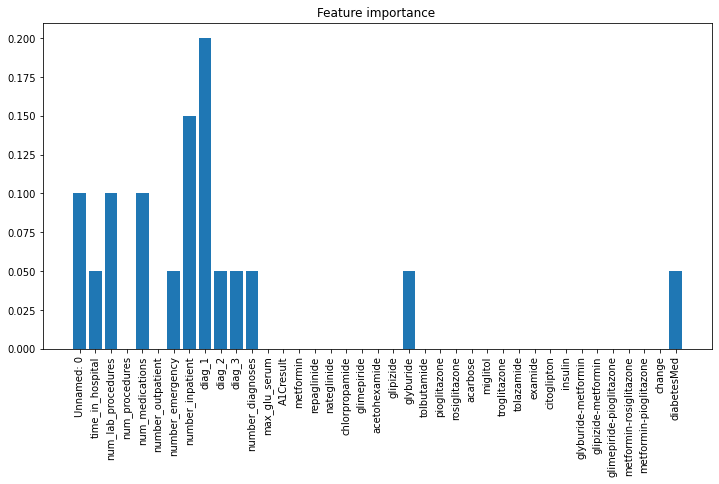

In [13]:
# We can obtain feature importance if tree based models are adopted. 
# For example, we use AdaBoostClassifier and OrdinalEncoder for categorical features.

from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import OrdinalEncoder

treebased_predictor = Pipeline(
    steps=[
           #feature engineering component 
        ("preprocessor", ColumnTransformer(transformers=[
                                              # we use selector to indentify features based on its data type
                                              # Normalize numerical features
                                               ("num", StandardScaler(), selector(dtype_exclude="category")), 
                                              # Encoding (transforming) categorical features to what understandable by the model
                                              ("cat", OrdinalEncoder(handle_unknown="ignore"), selector(dtype_include="category")),
                                            ]
                                          )
        ),
        # model component
        ("classifier",
         AdaBoostClassifier(n_estimators=20, learning_rate=1.0),
        ),
    ]
)

treebased_predictor.fit(X_train, y_train)
# y_pred = treebased_predictor.predict(X_test)

feature_importances = treebased_predictor.named_steps['classifier'].feature_importances_ 

plt.figure(figsize=(12, 6))
plt.bar(x=range(len(X_train.columns)), height=feature_importances)
plt.xticks(range(len(X_train.columns)), X_train.columns, rotation=90)
plt.title("Feature importance ")
plt.show()

### Use **fairlearn.metrics.MetricFrame** class to inspect model's fairness

We know that there are sensitive features in our data, and we want to ensure that we’re not harming individuals due to membership in any of these groups. For this purpose, Fairlearn provides the fairlearn.metrics.MetricFrame class. 

The **fairlearn.metrics.MetricFrame** object requires a minimum of four arguments:

* The underlying metric function(s) to be evaluated
* The true values
* The predicted values
* The sensitive feature values

Metric functions must have a signature ''fn(y_true, y_pred)'', i.e., require only two arguments.



In [14]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate, false_negative_rate, false_positive_rate

import functools
import numpy as np

def insensitive_roc_auc(y_true, y_score):
    #to handle subgroups with only one class.
    if sum(y_true)!=len(y_true) and sum(y_true)!=0:
        return skm.roc_auc_score(y_true, y_score)
    else:
        return np.nan

def samplesize(y_true, y_score):
    return len(y_true)

#Metrics 
metric_fns = {'samplesize': samplesize, 
              'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their label
              'FNR': false_negative_rate, 
              'FPR': false_positive_rate, 
              'accuracy': skm.accuracy_score,
              'average_precision': skm.average_precision_score,
              'roc_auc_score': insensitive_roc_auc 
              }

grouped_on_race = MetricFrame(metric_fns,
                             y_test, y_pred,
                             sensitive_features=A_test['race'])

The **fairlearn.metrics.MetricFrame** has the **overall** property, 
which contains the metrics evaluated on the entire dataset. We see that this contains the same values calculated above:

In [15]:
#We can inspect the overall values, and check they are as expected:
assert grouped_on_race.overall['selection_rate'] == selection_rate(y_test, y_pred)
assert grouped_on_race.overall['accuracy'] == skm.accuracy_score(y_test, y_pred)
print(grouped_on_race.overall)

samplesize              27371
selection_rate       0.083263
FNR                  0.730379
FPR                  0.075586
accuracy             0.898506
average_precision    0.063445
roc_auc_score        0.597018
dtype: object


#### Performance breakdown by subgroups
The other property in the **fairlearn.metrics.MetricFrame** object is **by_group**. This contains the metrics evaluated on each subgroup defined by the categories in the sensitive_features (*race* in our case). 

In [16]:
grouped_on_race.by_group

,samplesize,selection_rate,FNR,FPR,accuracy,average_precision,roc_auc_score
race,,,,,,,
?,858,0.043124,0.826087,0.039521,0.939394,0.040946,0.567196
AfricanAmerican,4845,0.067699,0.714286,0.061545,0.920537,0.052709,0.612085
Asian,230,0.06087,0.75,0.050459,0.913043,0.092702,0.599771
Caucasian,20368,0.089405,0.729238,0.081225,0.890809,0.066859,0.594768
Hispanic,584,0.089041,0.740741,0.08079,0.888699,0.069147,0.589235
Other,486,0.055556,0.777778,0.052411,0.934156,0.030864,0.584906


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5e718debd0>,
      dtype=object)

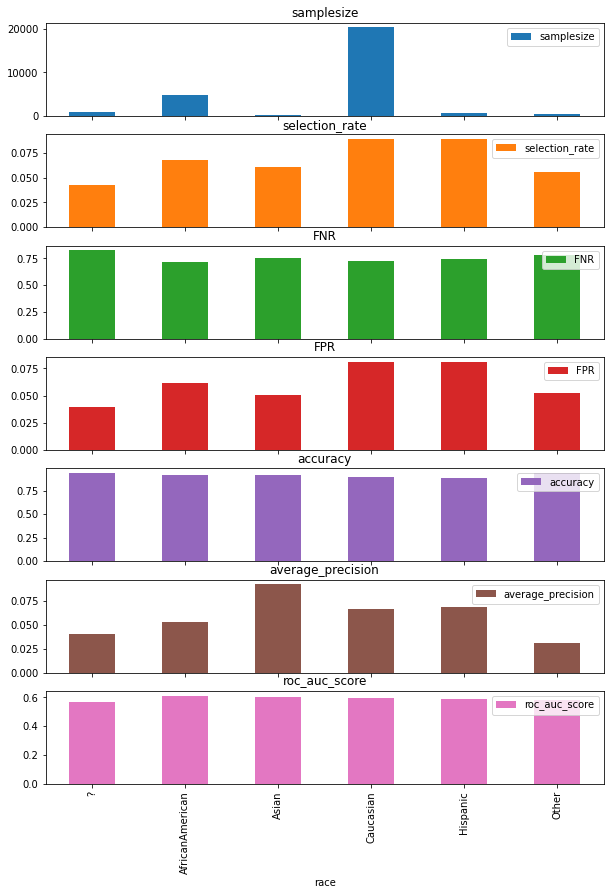

In [17]:
# Plot the metric values
grouped_on_race.by_group.plot.bar(subplots=True, figsize=(10, 14))

Are there any differences in the performance metrics by race that stand out to you?

**Write your answer in this text cell:**

The metrics for Caucasians seem to be the highest. This could be because there is significantly more recorded data for Caucasians. It is possible that the model is favoring the race that is more prevalent in the data, in this case Caucasians.

#### Quantifying Disparities 
**Fairlearn** provides several means of aggregating metrics across the subgroups, so that disparities can be readily quantified.

In [18]:
'''
The simplest of these aggregations is group_min(), which reports the minimum value 
seen for a subgroup for each underlying metric (as well as group_max()). 
This is useful if there is a mandate that “no subgroup should have an accuracy() of less than 0.8.” 
'''
grouped_on_race.group_min()

samplesize                230
selection_rate       0.043124
FNR                  0.714286
FPR                  0.039521
accuracy             0.888699
average_precision    0.030864
roc_auc_score        0.567196
dtype: object

In [19]:
'''
The difference between metrics achieved on subgroups can be quantified 
in terms of a difference between the subgroup with the highest value of the metric, and the subgroup with the lowest value.
'''
grouped_on_race.difference(method='between_groups')

samplesize              20138
selection_rate       0.046281
FNR                  0.111801
FPR                  0.041704
accuracy             0.050695
average_precision    0.061838
roc_auc_score        0.044889
dtype: object

In [20]:
'''
We can also evaluate the difference relative to the corresponding overall value of the metric. 
In this case we take the absolute value, so that the result is always positive:'
'''
grouped_on_race.difference(method='to_overall')

samplesize              27141
selection_rate        0.04014
FNR                  0.095708
FPR                  0.036065
accuracy             0.040888
average_precision    0.032581
roc_auc_score        0.029822
dtype: object

#### Intersections of sensitive features
We can examine the intersections of sensitive features by passing multiple columns to the fairlearn.metrics.MetricFrame constructor:

In [21]:
grouped_on_race_and_sex = MetricFrame(metric_fns,
                                      y_test, y_pred,
                                      sensitive_features=A_test[['race', 'gender']])

In [22]:
grouped_on_race_and_sex.by_group

samplesize  ... roc_auc_score
race            gender             ...              
?               Female        436  ...      0.516003
                Male          422  ...       0.63301
AfricanAmerican Female       2919  ...       0.62928
                Male         1926  ...       0.58458
Asian           Female        116  ...       0.46875
                Male          114  ...      0.668632
Caucasian       Female      10332  ...      0.597627
                Male        10036  ...      0.591637
Hispanic        Female        316  ...      0.586667
                Male          268  ...      0.593562
Other           Female        243  ...      0.470464
                Male          243  ...      0.810417

[12 rows x 7 columns]

Look over the metrics by race and sex. Are there any metrics that have notable intersectional disparities?

**Write your answer in this text cell:**

The FNR for the Asian and Other racial groups vary distinctly when broken down by gender. Despite having a similar sample size for both males and females, in both racial categories, females have a FNR of 1, whereas males have a significantly lower FNR.



#### Control Features
There is a further way we can slice up our data. We have features for the patients' *admission_type_id* (Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available). When making predictions for readmission, it is acceptable that patients who were admitted due to a specific reason this time to have higher rate of readmission. However, within each admission type, we do not want a disparity between gender. To handle such senario, we introduce the concept of **control features**.

Control features are introduced by the `control_features= argument` to the `fairlearn.metrics.MetricFrame` object:

In [23]:
cond_admissiontype = MetricFrame( {'sample size': samplesize,
                          'selection_rate': selection_rate,  
                          'accuracy': skm.accuracy_score,
                          'roc_auc_score': insensitive_roc_auc },
                                y_test, y_pred,
                                sensitive_features=A_test[['gender']],
                                control_features=A_test['admission_type'])

In [24]:
'''
This has an immediate effect on the overall property. 
Instead of having one value for each metric, we now have a value for each unique value of the control feature:
'''
cond_admissiontype.overall

,sample size,selection_rate,accuracy,roc_auc_score
admission_type,,,,
Elective,5527,0.067306,0.91641,0.607746
Emergency,13851,0.081655,0.899213,0.589263
NULL,1865,0.179625,0.798391,0.599332
Newborn,2,0.0,1.0,NaN
Not Available,1027,0.023369,0.96592,0.488189
Not Mapped,139,0.057554,0.884892,0.469466
Trauma Center,11,0.0,1.0,NaN
Urgent,4949,0.082643,0.900384,0.594085


In [25]:
cond_admissiontype.by_group

sample size selection_rate  accuracy roc_auc_score
admission_type gender                                                   
Elective       Female        2881       0.062131  0.922249      0.611456
               Male          2646        0.07294  0.910053      0.603776
Emergency      Female        7411       0.085144  0.895021      0.590668
               Male          6440        0.07764  0.904037      0.587165
NULL           Female         927       0.183387  0.789644      0.584125
               Male           938       0.175906  0.807036      0.615345
Newborn        Female           1            0.0       1.0           NaN
               Male             1            0.0       1.0           NaN
Not Available  Female         545       0.018349  0.968807      0.490706
               Male           482       0.029046  0.962656      0.485356
Not Mapped     Female          82       0.073171  0.853659      0.460526
               Male            57       0.035088  0.929825      0.481818
Trauma Center  Female           4            0.0       1.0           NaN
               Male             7            0.0       1.0           NaN
Urgent         Female        2511       0.077658  0.908801      0.613787
               Male          2438       0.087777  0.891715      0.576066

In fact, sensitive features can be used as control features as well. For example, if we assume that the readmission rate can be naturally different for people in different age groups, i.e., older people are more likely to be readmitted while young adults are less vunerable, we can consider 'age' as a control feature (as above) but maintain equality across gender or race.

**In the code cell below, calculate the selecton rate, accuracy, and roc_auc_score using "age" as a control feature and "gender" and "race" as sensitive features.** (For reference, see how we used `MetricFrame` above.) 

In [29]:
cond_agetype = MetricFrame( {'sample size': samplesize,
                          'selection_rate': selection_rate,  
                          'accuracy': skm.accuracy_score,
                          'roc_auc_score': insensitive_roc_auc },
                                y_test, y_pred,
                                sensitive_features=A_test[['gender','race']],
                                control_features=A_test['age'])

cond_agetype.overall
cond_agetype.by_group

Found 120 subgroups. Evaluation may be slow


sample size  ... roc_auc_score
age      gender race                         ...              
[0-10)   Female ?                         1  ...           NaN
                AfricanAmerican           3  ...           NaN
                Asian                     1  ...           NaN
                Caucasian                31  ...           NaN
                Hispanic                  1  ...           NaN
...                                     ...  ...           ...
[90-100) Male   AfricanAmerican          17  ...           NaN
                Asian                     3  ...           NaN
                Caucasian               192  ...      0.649421
                Hispanic                  1  ...           NaN
                Other                     2  ...           NaN

[120 rows x 4 columns]

## Step 5: Mitigate the unfairness of the classifier.

**Fairlearn** provide preprocessing, postprocessing, and reductions modules for unfairness mitigation.




In [30]:
X_train_ = unmitigated_predictor.named_steps['preprocessor'].fit_transform(X_train)
X_test_ = unmitigated_predictor.named_steps['preprocessor'].transform(X_test)

### Mitigating Difference with Postprocessing

We attempt to mitigate the disparities in the classifier using the Fairlearn postprocessing algorithm **ThresholdOptimizer**. This algorithm finds a suitable threshold for the scores (class probabilities) produced by the model by optimizing the accuracy rate under the constraint that the equalized odds (with respect to the sensitive feature and the outcome) is zero, using the training data. Here we consider race as the sensitive feature.

In [31]:
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
postprocess_est = ThresholdOptimizer(
    estimator=unmitigated_predictor.named_steps['classifier'],
    constraints="false_negative_rate_parity",
    objective='balanced_accuracy_score'
    )

In [32]:
postprocess_est.fit(X_train_.toarray(), y_train, 
                    sensitive_features=A_train['race'])

ThresholdOptimizer(constraints='false_negative_rate_parity',
                   estimator=LogisticRegression(C=0.1,
                                                class_weight={0: 1, 1: 10},
                                                max_iter=1000),
                   objective='balanced_accuracy_score')

In [33]:
postprocess_preds = postprocess_est.predict(X_test_.toarray(),
                                            sensitive_features=A_test['race'])

Fairlearn provides the following function,`plot_threshold_optimizer`, to interprete how is the decision made in `ThresholdOptimizer`. It seeks a threhold for predicted scores that can minimize the disparity estimated by the `constraints` (*false_negative_rate_parity*) and the performance estimated by the `objective`  (*balanced_accuracy_score*). 

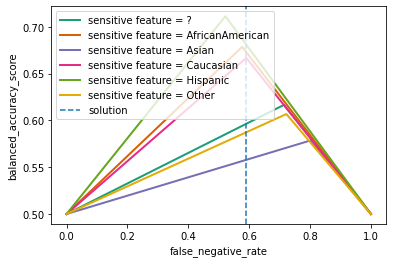

In [34]:
plot_threshold_optimizer(postprocess_est, ax=None, show_plot=True)

Let's further compare the mitigated and unmitigated models' performance.

In [35]:
metric_fns = {'FNR': false_negative_rate, 
              'FPR': false_positive_rate, 
              'accuracy': skm.accuracy_score,
              'average_precision': skm.average_precision_score,
              'roc_auc_score': insensitive_roc_auc 
              }

modelnames, accuracies, disparities = [], [], []

#get performance for the unmitigated_predictor 
accuracy_metric_frame = MetricFrame(metric_fns, 
                                    y_test, y_pred, 
                                    sensitive_features=A_test['race'])

accuracies.append(accuracy_metric_frame.overall)
disparities.append(accuracy_metric_frame.ratio(method='to_overall'))
modelnames.append('unmitigated_predictor')

#get performance for the mitigated predictor from GridSearch
accuracy_metric_frame = MetricFrame(metric_fns, 
                                    y_test, postprocess_preds, 
                                    sensitive_features=A_test['race'])

accuracies.append(accuracy_metric_frame.overall)
disparities.append(accuracy_metric_frame.ratio(method='to_overall'))
modelnames.append('mitigated_predictor')


Plot the **disparities** between groups and overall **accuracy** metrics for the unmitigated and mitigated predictors below:

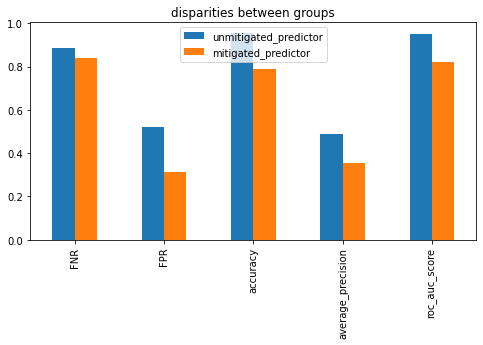

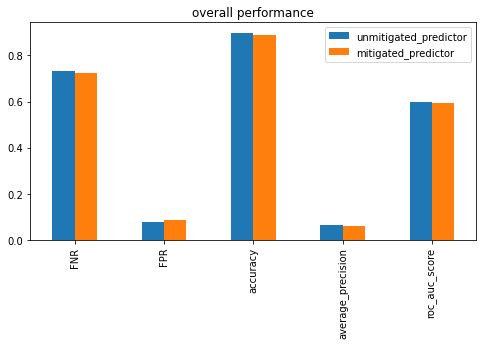

In [37]:
# write your code here
pd.DataFrame(disparities, index=modelnames).T.plot.bar(figsize=(8,4),
                                                       title='disparities between groups')
pd.DataFrame(accuracies, index=modelnames).T.plot.bar(figsize=(8,4),
                                                       title='overall performance')

In [38]:
accuracy_metric_frame.by_group

,FNR,FPR,accuracy,average_precision,roc_auc_score
race,,,,,
?,0.608696,0.223952,0.765734,0.034285,0.583676
AfricanAmerican,0.714286,0.060272,0.921775,0.053326,0.612721
Asian,0.75,0.275229,0.7,0.051035,0.487385
Caucasian,0.7281,0.081687,0.890416,0.066913,0.595106
Hispanic,0.814815,0.066427,0.898973,0.059717,0.559379
Other,0.666667,0.226415,0.765432,0.021355,0.553459


In [39]:
accuracy_metric_frame = MetricFrame(metric_fns, 
                                    y_test, y_pred, 
                                    sensitive_features=A_test['race'])
accuracy_metric_frame.by_group

,FNR,FPR,accuracy,average_precision,roc_auc_score
race,,,,,
?,0.826087,0.039521,0.939394,0.040946,0.567196
AfricanAmerican,0.714286,0.061545,0.920537,0.052709,0.612085
Asian,0.75,0.050459,0.913043,0.092702,0.599771
Caucasian,0.729238,0.081225,0.890809,0.066859,0.594768
Hispanic,0.740741,0.08079,0.888699,0.069147,0.589235
Other,0.777778,0.052411,0.934156,0.030864,0.584906


How do the unmitigated and mitigated predictors compare?

**Write your answer in this text cell:**
In the first graph, there is some difference between the mitigated and unmitigated predictors. In the second graph, there is not much of a difference, which means that we have mitigated the bias to some extent.